In [2]:
# !pip install yfinance

In [35]:
!pip install optuna-integration[tfkeras]

  Obtaining dependency information for optuna-integration[tfkeras] from https://files.pythonhosted.org/packages/fb/72/96fb1f0b6c72af7d2a5c3029f864d38eda47150c939510b9a9f5abf143db/optuna_integration-4.2.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/97.6 kB ? eta -:--:--
   ---------------------------------------- 97.6/97.6 kB 5.5 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
[I 2025-03-19 17:29:08,841] A new study created in memory with name: no-name-35500cb8-1adc-48e3-84ab-29191b4f8ab9


Price       Date      Close       High        Low       Open  Volume
0     1927-12-30  17.660000  17.660000  17.660000  17.660000       0
1     1928-01-03  17.760000  17.760000  17.760000  17.760000       0
2     1928-01-04  17.719999  17.719999  17.719999  17.719999       0
3     1928-01-05  17.549999  17.549999  17.549999  17.549999       0
4     1928-01-06  17.660000  17.660000  17.660000  17.660000       0
Training data shape: (19511, 30, 1)
Validation data shape: (3903, 30, 1)
Testing data shape: (4878, 30, 1)
Starting hyperparameter optimization...


[I 2025-03-19 17:30:50,434] Trial 0 finished with value: 2.299184416187927e-05 and parameters: {'lstm_units': 70, 'dropout_rate': 0.017168034792564235, 'learning_rate': 0.025287295118708027, 'batch_size': 16}. Best is trial 0 with value: 2.299184416187927e-05.
[I 2025-03-19 17:33:40,770] Trial 1 finished with value: 2.6096533474628814e-05 and parameters: {'lstm_units': 207, 'dropout_rate': 0.0632442439630207, 'learning_rate': 0.007610099763115913, 'batch_size': 16}. Best is trial 0 with value: 2.299184416187927e-05.
[I 2025-03-19 17:34:19,451] Trial 2 finished with value: 0.000947401684243232 and parameters: {'lstm_units': 36, 'dropout_rate': 0.010539174499322401, 'learning_rate': 0.09972379291990446, 'batch_size': 32}. Best is trial 0 with value: 2.299184416187927e-05.
[I 2025-03-19 17:35:23,447] Trial 3 finished with value: 4.1228911868529394e-05 and parameters: {'lstm_units': 38, 'dropout_rate': 0.2964417976170849, 'learning_rate': 7.297550580597608e-05, 'batch_size': 32}. Best is t

Best hyperparameters: {'lstm_units': 44, 'dropout_rate': 0.047264844756738644, 'learning_rate': 0.003695869320777851, 'batch_size': 64}
Best validation loss: 2.271314042445738e-05


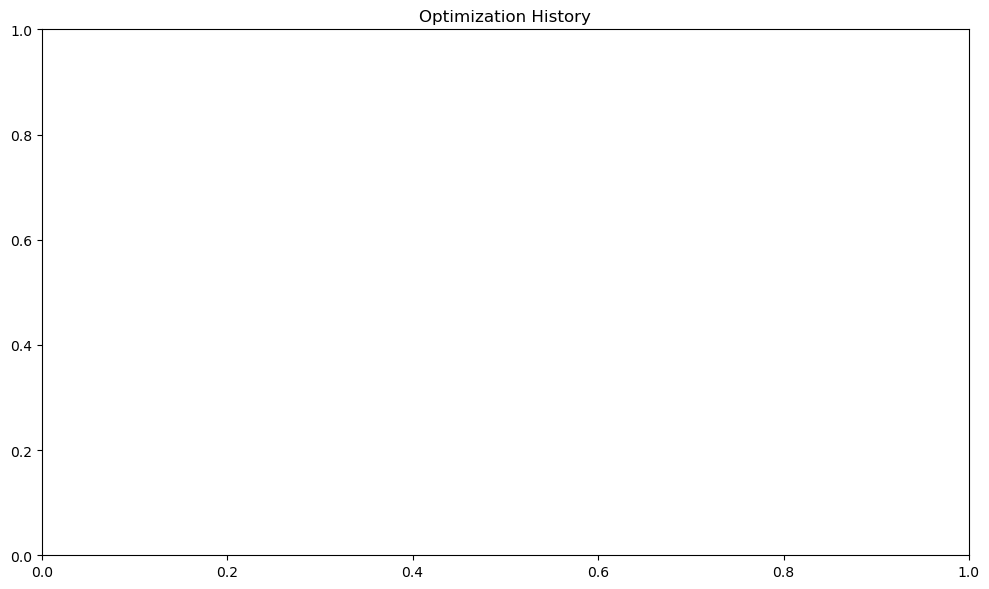

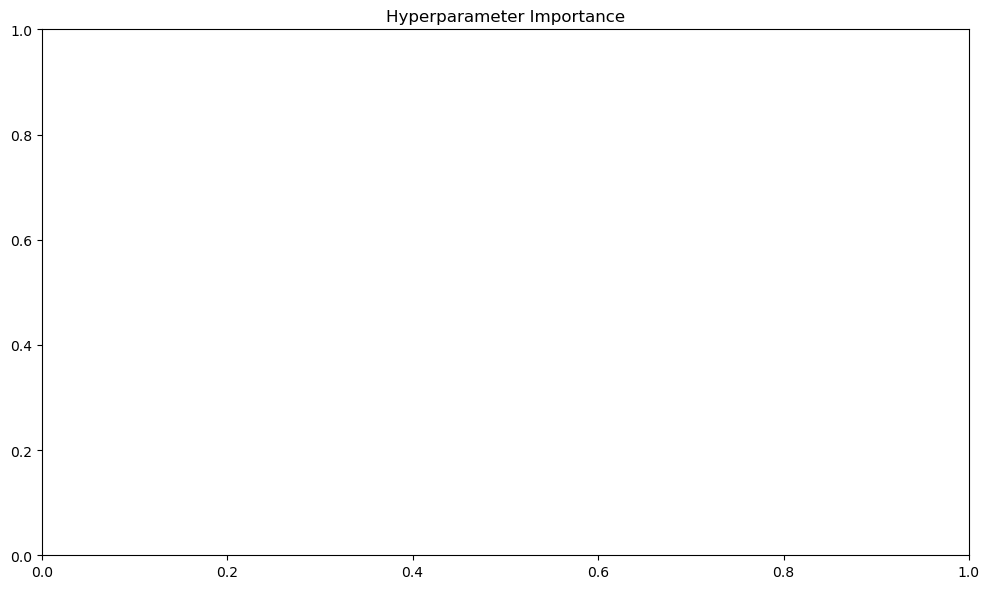

Training final model with best hyperparameters...
Epoch 1/100
244/244 [==============================] - 4s 9ms/step - loss: 1.3821e-05 - val_loss: 2.9021e-05
Epoch 2/100
244/244 [==============================] - 2s 8ms/step - loss: 1.1485e-06 - val_loss: 2.7693e-05
Epoch 3/100
244/244 [==============================] - 2s 8ms/step - loss: 1.2209e-06 - val_loss: 3.0123e-05
Epoch 4/100
244/244 [==============================] - 2s 8ms/step - loss: 1.1531e-06 - val_loss: 2.6139e-05
Epoch 5/100
244/244 [==============================] - 2s 8ms/step - loss: 1.2349e-06 - val_loss: 2.7197e-05
Epoch 6/100
244/244 [==============================] - 2s 8ms/step - loss: 1.1351e-06 - val_loss: 6.0765e-05
Epoch 7/100
244/244 [==============================] - 2s 8ms/step - loss: 1.1844e-06 - val_loss: 2.5006e-05
Epoch 8/100
244/244 [==============================] - 2s 8ms/step - loss: 9.6825e-07 - val_loss: 4.1012e-05
Epoch 9/100
244/244 [==============================] - 2s 8ms/step - loss: 1.2

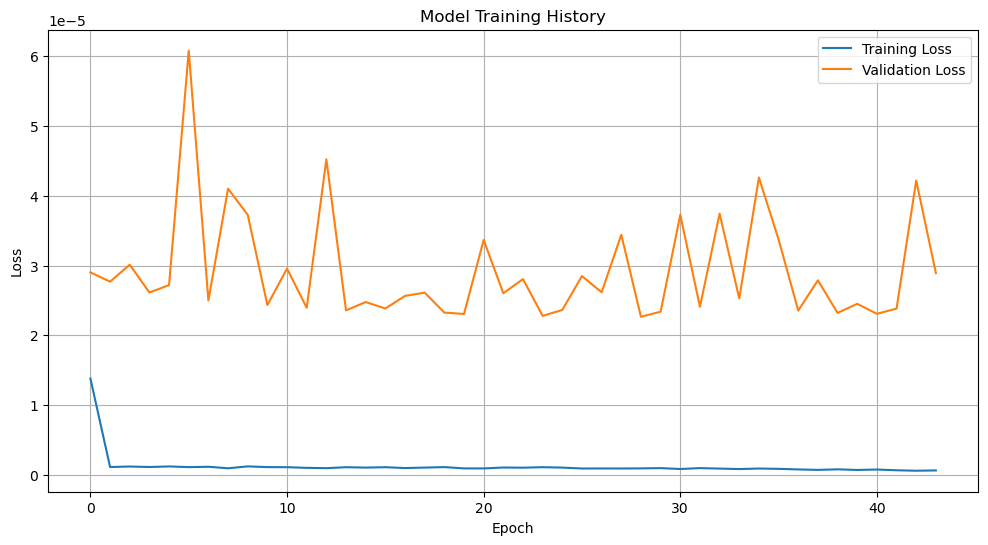

153/153 [==============================] - 1s 3ms/step


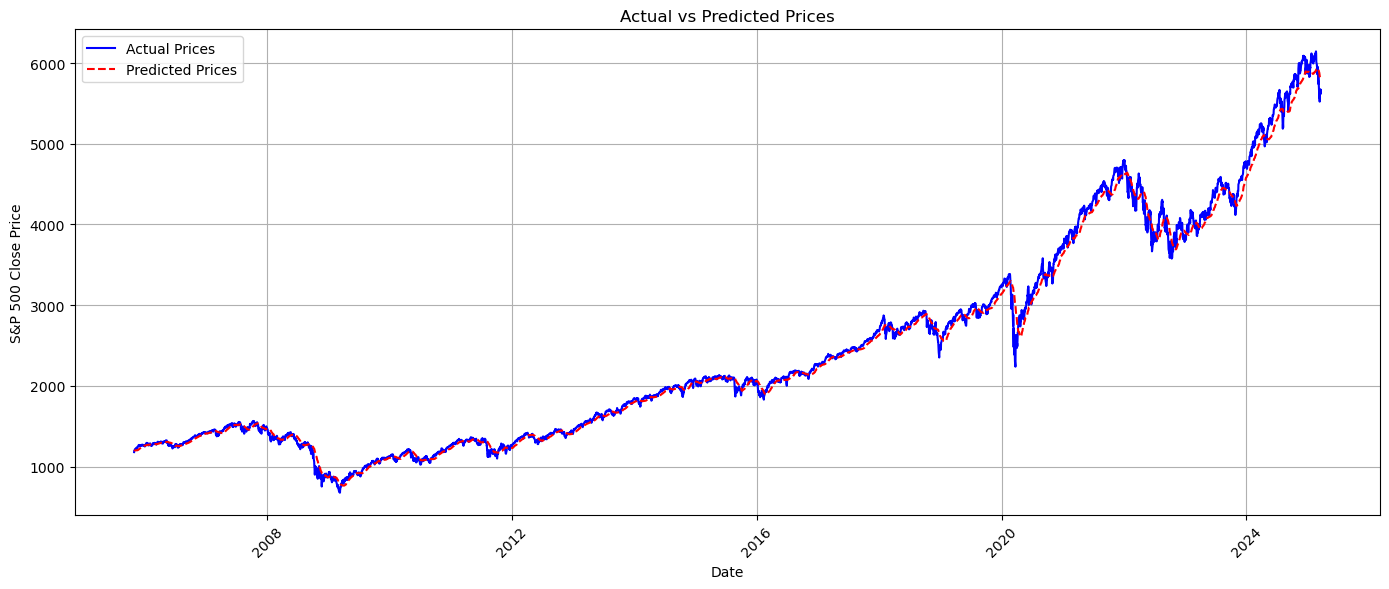

Mean Absolute Error (MAE): $65.53
Mean Squared Error (MSE): $9159.02
Root Mean Squared Error (RMSE): $95.70
Mean Absolute Percentage Error (MAPE): 2.64%
Model saved as 'sp500_prediction_model.h5'


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Input, Concatenate, Multiply, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.integration import TFKerasPruningCallback
import warnings
warnings.filterwarnings('ignore')

# #######################################
# Step 1: Load and preprocess the data using yfinance
# #######################################
"""
Step 1: Load and preprocess the data using yfinance
- yfinance is used to download historical data for the S&P500 index (^GSPC).
- The data is cleaned by removing multi-index column levels and resetting the index for clarity.
- The 'Close' column is used as the target variable for prediction.
"""
def load_data():
    # Download S&P500 data
    data = yf.download(tickers="^GSPC", interval="1d", auto_adjust=True)
    df_data = pd.DataFrame(data)
    df_data.columns = df_data.columns.droplevel(1)  # Remove multi-index column level
    df_data = df_data.rename_axis("Date").reset_index()  # Reset index for clarity
    return df_data

# #######################################
# Step 2: Preprocess the data
# #######################################
"""
Step 2: Preprocess the data
- The 'Close' prices are extracted and reshaped into a 2D array.
- The data is normalized using MinMaxScaler to scale values between 0 and 1.
- A sliding window approach is used to create input sequences (X) and target values (y).
  - Each input sequence consists of 'lookback' days of historical data.
  - The target value is the 'Close' price on the next day.
"""
def preprocess_data(df_data, lookback):
    # Use 'Close' prices for prediction
    data = df_data['Close'].values.reshape(-1, 1)
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    # Create sequences of historical data
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y), scaler

# #######################################
# Step 3: Build the attention-based model
# #######################################
"""
Step 3: Build the attention-based model
- The model consists of an LSTM layer followed by an attention mechanism.
- The attention mechanism computes attention scores for each time step in the LSTM output.
- These scores are used to create a context vector, which summarizes the most relevant information.
- A fully connected layer produces the final prediction.
"""
def attention_block(inputs):
    # Compute attention scores
    attention = Dense(1, activation='tanh')(inputs)
    attention = tf.nn.softmax(attention, axis=1)
    
    # Apply attention weights to the inputs
    context = Multiply()([inputs, attention])
    context = Lambda(lambda x: tf.reduce_sum(x, axis=1))(context)
    return context

def build_model(lookback, lstm_units, dropout_rate=0.2, learning_rate=0.001):
    inputs = Input(shape=(lookback, 1))
    
    # LSTM layer with dropout
    lstm_out = LSTM(lstm_units, return_sequences=True, dropout=dropout_rate)(inputs)
    
    # Attention mechanism
    attention_out = attention_block(lstm_out)
    
    # Fully connected layer
    outputs = Dense(1)(attention_out)
    
    model = Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# #######################################
# Step 4: Define Optuna objective function for hyperparameter tuning
# #######################################
"""
Step 4: Define Optuna objective function for hyperparameter tuning
- This function defines the objective that Optuna will optimize.
- It builds and trains models with different hyperparameter configurations.
- The validation loss is used as the metric to minimize.
"""
def objective(trial, X_train, y_train, X_val, y_val, lookback):
    # Define hyperparameters to optimize
    lstm_units = trial.suggest_int('lstm_units', 32, 256, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    
    # Build model with the suggested hyperparameters
    model = build_model(lookback, lstm_units, dropout_rate, learning_rate)
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # TFKerasPruningCallback for Optuna to prune unpromising trials
    pruning_callback = TFKerasPruningCallback(trial, 'val_loss')
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=batch_size,
        callbacks=[early_stopping, pruning_callback],
        verbose=0
    )
    
    # Return the best validation loss
    return min(history.history['val_loss'])

# #######################################
# Step 5: Run hyperparameter optimization with Optuna
# #######################################
"""
Step 5: Run hyperparameter optimization with Optuna
- Create an Optuna study to find the best hyperparameters.
- The study minimizes the validation loss.
- After optimization, the best hyperparameters are used to train the final model.
"""
def optimize_hyperparameters(X_train, y_train, lookback, n_trials=30):
    # Split training data into train and validation sets
    val_split = int(0.8 * len(X_train))
    X_train_subset, X_val = X_train[:val_split], X_train[val_split:]
    y_train_subset, y_val = y_train[:val_split], y_train[val_split:]
    
    # Create Optuna study
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
    )
    
    # Define objective function with fixed data parameters
    objective_with_params = lambda trial: objective(
        trial, X_train_subset, y_train_subset, X_val, y_val, lookback
    )
    
    # Optimize
    study.optimize(objective_with_params, n_trials=n_trials)
    
    print("Best hyperparameters:", study.best_params)
    print("Best validation loss:", study.best_value)
    
    # Visualize optimization results if available
    try:
        from optuna.visualization import plot_optimization_history, plot_param_importances
        
        plt.figure(figsize=(10, 6))
        plot_optimization_history(study)
        plt.title("Optimization History")
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plot_param_importances(study)
        plt.title("Hyperparameter Importance")
        plt.tight_layout()
        plt.show()
    except:
        print("Optuna visualization is not available or couldn't be displayed.")
    
    return study.best_params

# #######################################
# Step 6: Train the final model with the best hyperparameters
# #######################################
"""
Step 6: Train the final model with the best hyperparameters
- The model is trained using the best hyperparameters found by Optuna.
- Early stopping is used to prevent overfitting.
"""
def train_final_model(X_train, y_train, X_val, y_val, lookback, best_params):
    # Build model with best hyperparameters
    model = build_model(
        lookback,
        lstm_units=best_params['lstm_units'],
        dropout_rate=best_params['dropout_rate'],
        learning_rate=best_params['learning_rate']
    )
    
    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=best_params['batch_size'],
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model

# #######################################
# Step 7: Make predictions
# #######################################
"""
Step 7: Make predictions
- The trained model is used to predict future values on the test data (X_test).
- Predictions are rescaled back to the original value range using the MinMaxScaler.
"""
def predict(model, X_test, scaler):
    # Reshape X_test to match model input shape if needed
    if len(X_test.shape) == 2:
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        
    # Make predictions
    predictions = model.predict(X_test)
    
    # Convert predictions to original scale
    if predictions.shape[1] == 1:
        predictions = scaler.inverse_transform(predictions)
    else:
        predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
        
    return predictions

# #######################################
# Step 8: Plot real vs predicted values and evaluate model
# #######################################
def plot_predictions(df_data, predictions, test_start_idx):
    actual_prices = df_data['Close'].values[test_start_idx:test_start_idx+len(predictions)]
    dates = df_data['Date'].values[test_start_idx:test_start_idx+len(predictions)]
    
    plt.figure(figsize=(14, 6))
    plt.plot(dates, actual_prices, label="Actual Prices", color='blue')
    plt.plot(dates, predictions, label="Predicted Prices", color='red', linestyle='dashed')
    plt.xlabel("Date")
    plt.ylabel("S&P 500 Close Price")
    plt.title("Actual vs Predicted Prices")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Calculate evaluation metrics
    mae = np.mean(np.abs(actual_prices - predictions.flatten()))
    mse = np.mean((actual_prices - predictions.flatten())**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual_prices - predictions.flatten()) / actual_prices)) * 100
    
    print(f"Mean Absolute Error (MAE): ${mae:.2f}")
    print(f"Mean Squared Error (MSE): ${mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# #######################################
# Main execution
# #######################################
"""
Main execution
- Load the S&P500 data using yfinance.
- Preprocess the data to create input sequences and target values.
- Split the data into training, validation, and testing sets.
- Use Optuna to find the best hyperparameters.
- Build and train the attention-based LSTM model with the best hyperparameters.
- Make predictions on the test data and evaluate the model.
- Plot Real data vs Prediction data
"""
if __name__ == "__main__":
    # Load data
    df_data = load_data()
    print(df_data.head())  # Print the first few rows of the dataframe
    
    # Set the lookback period
    lookback = 30  # Default lookback period (will be tuned if included in hyperparameters)
    
    # Preprocess data
    X, y, scaler = preprocess_data(df_data, lookback)
    
    # Split into training and testing sets
    train_split = int(0.8 * len(X))
    X_train, X_test = X[:train_split], X[train_split:]
    y_train, y_test = y[:train_split], y[train_split:]
    
    # Further split training data into train and validation for hyperparameter tuning
    val_split = int(0.8 * len(X_train))
    X_train_final, X_val = X_train[:val_split], X_train[val_split:]
    y_train_final, y_val = y_train[:val_split], y_train[val_split:]
    
    # Reshape input data for LSTM (samples, time steps, features)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_train_final = X_train_final.reshape(X_train_final.shape[0], X_train_final.shape[1], 1)
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    print(f"Testing data shape: {X_test.shape}")
    
    # Run hyperparameter optimization
    print("Starting hyperparameter optimization...")
    best_params = optimize_hyperparameters(X_train, y_train, lookback, n_trials=25)
    
    # Train final model with best hyperparameters
    print("Training final model with best hyperparameters...")
    final_model = train_final_model(X_train_final, y_train_final, X_val, y_val, lookback, best_params)
    
    # Make predictions
    predictions = predict(final_model, X_test, scaler)
    
    # Plot and evaluate results
    test_start_idx = len(df_data) - len(X_test)
    plot_predictions(df_data, predictions, test_start_idx)
    
    # Save the model
    final_model.save('sp500_prediction_model_1_TICKERS.h5')
    print("Model saved as 'sp500_prediction_model.h5'")

In [37]:
def plot_recent_predictions(df_data, predictions, test_start_idx, days=30):
    """
    Plot the most recent N days of actual vs predicted values.
    
    Args:
        df_data: The original dataframe with Date and Close columns
        predictions: Model predictions (numpy array)
        test_start_idx: Starting index of test data in the original dataframe
        days: Number of recent days to display (default: 30)
    """
    # Get actual prices and dates for the test period
    actual_prices = df_data['Close'].values[test_start_idx:test_start_idx+len(predictions)]
    dates = df_data['Date'].values[test_start_idx:test_start_idx+len(predictions)]
    
    # Focus on only the most recent "days" data points
    if len(actual_prices) > days:
        actual_prices = actual_prices[-days:]
        predictions_recent = predictions[-days:]
        dates = dates[-days:]
    else:
        predictions_recent = predictions
        print(f"Warning: Requested {days} days but only {len(actual_prices)} days available")
    
    # Plot the data
    plt.figure(figsize=(14, 6))
    plt.plot(dates, actual_prices, label="Actual Prices", color='blue', linewidth=2)
    plt.plot(dates, predictions_recent, label="Predicted Prices", color='red', 
             linestyle='dashed', linewidth=2, marker='o', markersize=4)
    
    plt.xlabel("Date")
    plt.ylabel("S&P 500 Close Price")
    plt.title(f"Actual vs Predicted Prices (Last {len(dates)} Days)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    
    # Add annotations for the first and last points
    for i in [0, -1]:
        plt.annotate(f"${actual_prices[i]:.2f} vs ${predictions_recent[i][0]:.2f}",
                    (dates[i], actual_prices[i]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')
    
    # Calculate and display error metrics for this period
    mae = np.mean(np.abs(actual_prices - predictions_recent.flatten()))
    mape = np.mean(np.abs((actual_prices - predictions_recent.flatten()) / actual_prices)) * 100
    
    plt.figtext(0.15, 0.02, f"Recent MAE: ${mae:.2f} | MAPE: {mape:.2f}%", 
                ha="left", fontsize=10, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
    
    plt.show()

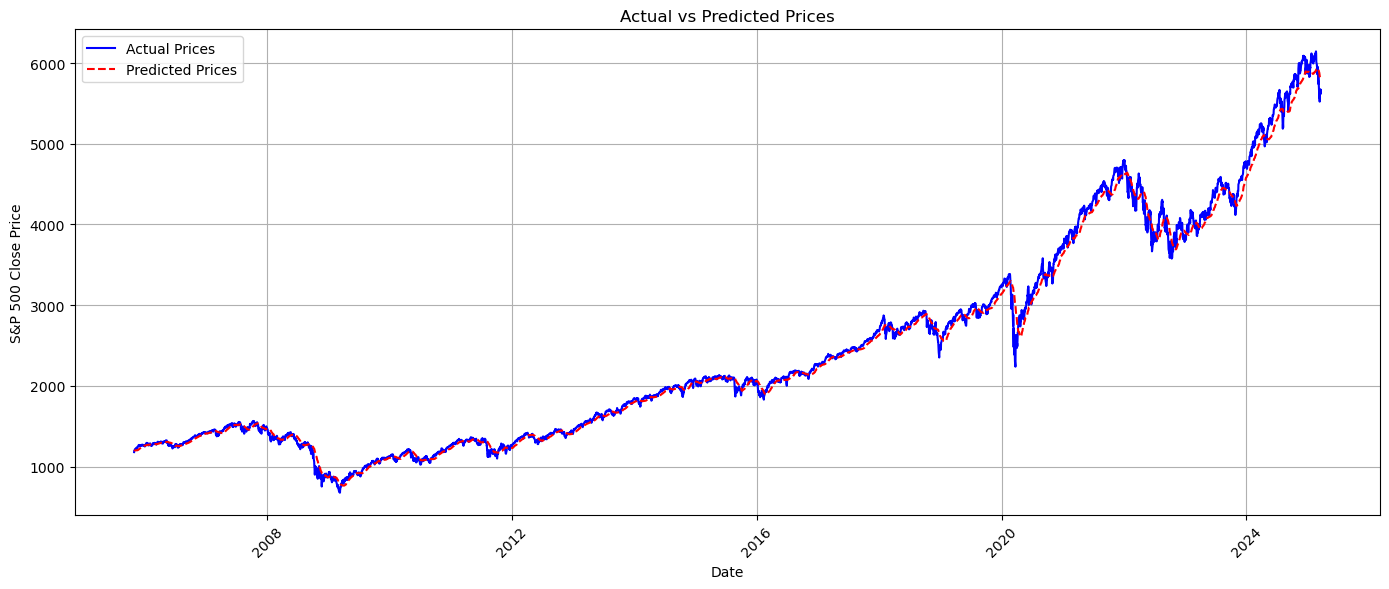

Mean Absolute Error (MAE): $65.53
Mean Squared Error (MSE): $9159.02
Root Mean Squared Error (RMSE): $95.70
Mean Absolute Percentage Error (MAPE): 2.64%


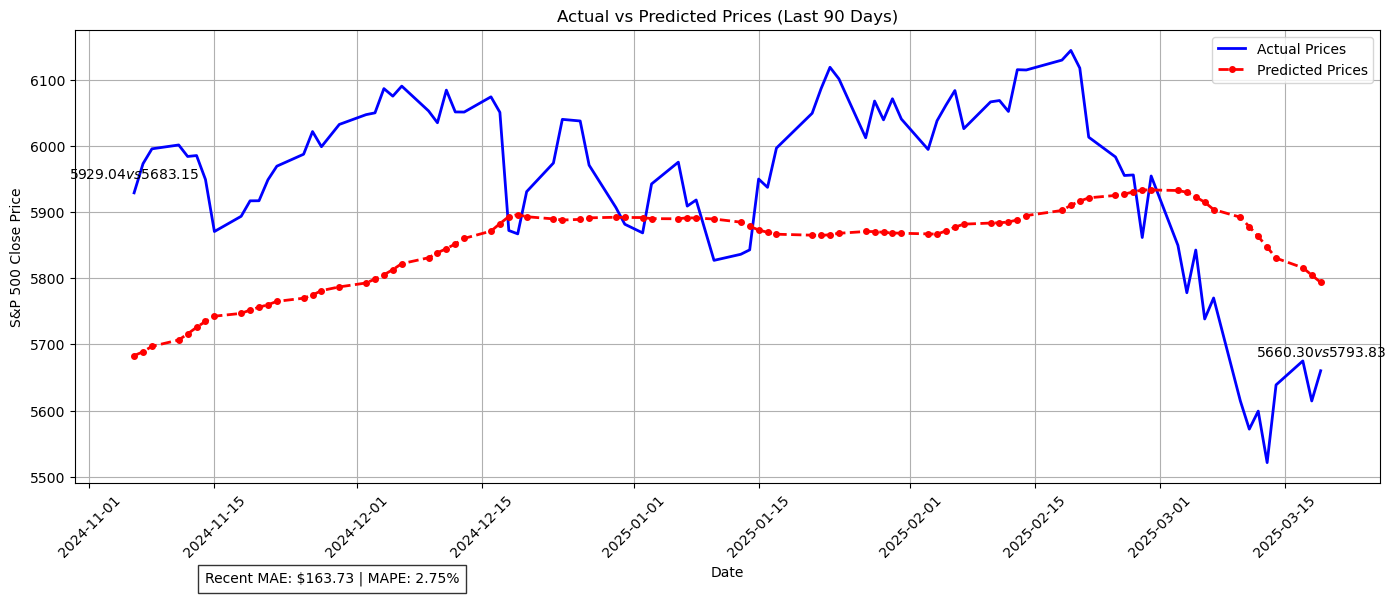

In [39]:
# Add this line to show the recent predictions:
plot_recent_predictions(df_data, predictions, test_start_idx, days=90)

# Save the model
final_model.save('sp500_prediction_model.h5')

1/1 [==============================] - 0s 320ms/step

===== S&P 500 NEXT TRADING DAY PREDICTION =====
Last trading day: 2025-03-19 00:00:00
Last closing price: $5660.30
Predicted price for 2025-03-20: $5782.15
Predicted change: $121.85 (2.15%)


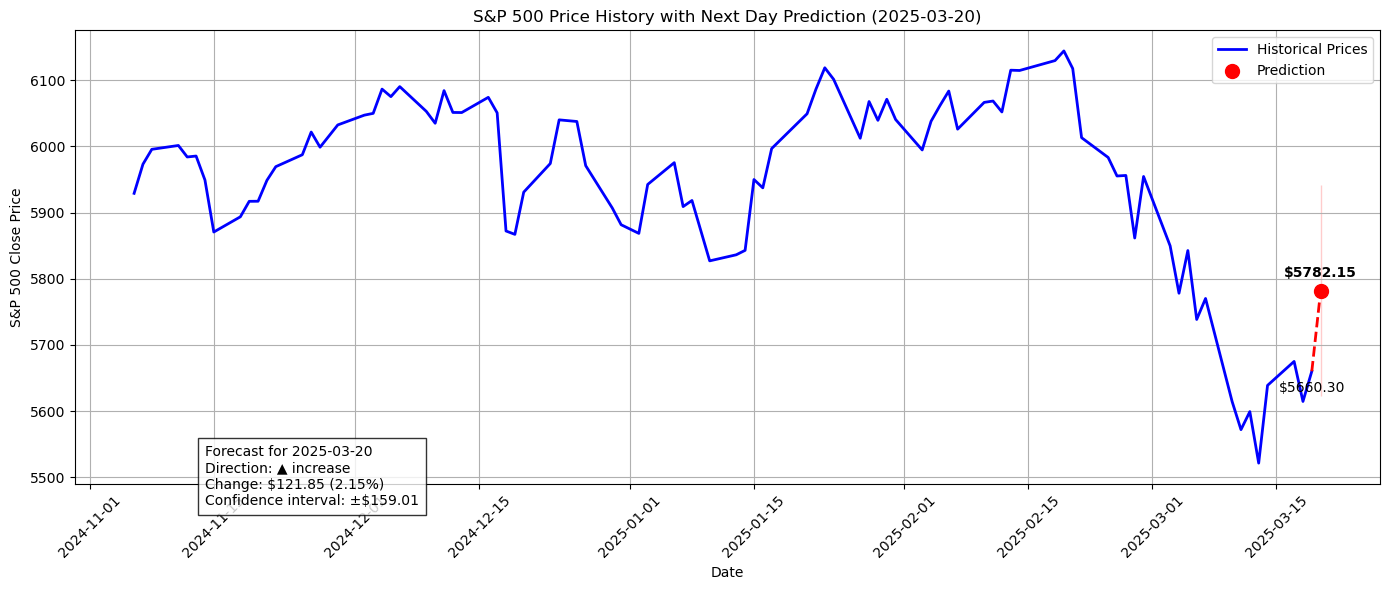

In [42]:
def predict_next_day(model, df_data, sequence_length=30):
    """
    Predict the S&P 500 price for the next trading day.
    
    Args:
        model: Trained LSTM model
        df_data: DataFrame containing historical stock data
        sequence_length: Length of input sequences used during training (default: 30)
        
    Returns:
        float: Predicted price for the next trading day
        str: Next trading day's date (estimated)
    """
    # Get the most recent data for the prediction window
    most_recent_data = df_data['Close'].values[-sequence_length:]
    
    # Scale the data as was done during training
    # Note: You should use the same scaler instance that was used for training
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Fit scaler on the entire dataset to maintain consistency
    scaler.fit(df_data['Close'].values.reshape(-1, 1))
    
    # Scale the most recent data
    scaled_data = scaler.transform(most_recent_data.reshape(-1, 1))
    
    # Reshape for LSTM input [samples, time steps, features]
    X_next = scaled_data.reshape(1, sequence_length, 1)
    
    # Make prediction
    scaled_prediction = model.predict(X_next)
    
    # Inverse transform to get the actual price
    predicted_price = scaler.inverse_transform(scaled_prediction)[0][0]
    
    # Estimate the next trading day's date
    # Simple approach: add 1 day to the last date and adjust for weekends
    import pandas as pd
    from datetime import datetime, timedelta
    
    last_date = pd.to_datetime(df_data['Date'].iloc[-1])
    next_date = last_date + timedelta(days=1)
    
    # Adjust for weekends
    if next_date.weekday() >= 5:  # 5=Saturday, 6=Sunday
        days_to_add = 8 - next_date.weekday()  # Go to Monday
        next_date = last_date + timedelta(days=days_to_add)
    
    return predicted_price, next_date.strftime('%Y-%m-%d')

def display_next_day_prediction(model, df_data, sequence_length=30):
    """
    Display the prediction for the next trading day along with recent performance.
    
    Args:
        model: Trained LSTM model
        df_data: DataFrame containing historical stock data
        sequence_length: Length of input sequences used during training
    """
    # Get the prediction for the next day
    next_price, next_date = predict_next_day(model, df_data, sequence_length)
    
    # Get the last actual price
    last_price = df_data['Close'].iloc[-1]
    last_date = df_data['Date'].iloc[-1]
    
    # Calculate change
    price_change = next_price - last_price
    percent_change = (price_change / last_price) * 100
    
    # Display the results
    print("\n===== S&P 500 NEXT TRADING DAY PREDICTION =====")
    print(f"Last trading day: {last_date}")
    print(f"Last closing price: ${last_price:.2f}")
    print(f"Predicted price for {next_date}: ${next_price:.2f}")
    print(f"Predicted change: ${price_change:.2f} ({percent_change:.2f}%)")
    print("===============================================")
    
    # Plot prediction with the recent history
    plot_with_next_day_prediction(df_data, next_price, next_date, days=90)
    
    return next_price, next_date

def plot_with_next_day_prediction(df_data, next_price, next_date, days=90):
    """
    Plot recent price history with the next day prediction.
    
    Args:
        df_data: DataFrame containing historical stock data
        next_price: Predicted price for the next trading day
        next_date: Next trading day's date string
        days: Number of recent days to display
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from datetime import datetime
    
    # Get recent actual data
    recent_data = df_data.tail(days).copy()
    
    # Create next day entry
    next_day_data = pd.DataFrame({
        'Date': [next_date],
        'Close': [next_price]
    })
    
    # Convert Date to datetime
    next_day_data['Date'] = pd.to_datetime(next_day_data['Date'])
    
    # Plot
    plt.figure(figsize=(14, 6))
    
    # Plot historical data
    plt.plot(recent_data['Date'], recent_data['Close'], 
             label="Historical Prices", color='blue', linewidth=2)
    
    # Plot prediction
    plt.plot([recent_data['Date'].iloc[-1], next_day_data['Date'].iloc[0]],
             [recent_data['Close'].iloc[-1], next_day_data['Close'].iloc[0]],
             color='red', linestyle='dashed', linewidth=2)
    
    # Add marker for the prediction
    plt.scatter(next_day_data['Date'], next_day_data['Close'], 
               color='red', s=100, marker='o', label="Prediction")
    
    # Annotate the prediction
    plt.annotate(f"${next_price:.2f}",
                (next_day_data['Date'].iloc[0], next_price),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                fontweight='bold')
    
    # Add confidence interval (based on MAPE)
    mape = 2.75  # From your recent data
    error_margin = next_price * mape / 100
    
    plt.fill_between([next_day_data['Date'].iloc[0]], 
                     [next_price - error_margin], 
                     [next_price + error_margin],
                     color='red', alpha=0.2)
    
    # Add labels for last known price
    last_price = recent_data['Close'].iloc[-1]
    plt.annotate(f"${last_price:.2f}",
                (recent_data['Date'].iloc[-1], last_price),
                textcoords="offset points",
                xytext=(0,-15),
                ha='center')
    
    plt.xlabel("Date")
    plt.ylabel("S&P 500 Close Price")
    plt.title(f"S&P 500 Price History with Next Day Prediction ({next_date})")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    
    # Add forecast information box
    last_date = recent_data['Date'].iloc[-1].strftime('%Y-%m-%d')
    change = next_price - last_price
    pct_change = (change / last_price) * 100
    direction = "▲" if change > 0 else "▼"
    
    info_text = f"Forecast for {next_date}\n" \
                f"Direction: {direction} {'increase' if change > 0 else 'decrease'}\n" \
                f"Change: ${abs(change):.2f} ({abs(pct_change):.2f}%)\n" \
                f"Confidence interval: ±${error_margin:.2f}"
    
    plt.figtext(0.15, 0.15, info_text, 
                ha="left", fontsize=10, 
                bbox={"facecolor":"white", "alpha":0.8, "pad":5})
    
    plt.show()

# Example usage
# After training your model:
from tensorflow.keras.models import load_model
loaded_model = load_model('sp500_prediction_model.h5')
next_price, next_date = display_next_day_prediction(loaded_model, df_data, sequence_length=30)